In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn import svm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import seaborn as sns
import pandas as pd
import pylab
from sklearn.metrics import confusion_matrix

In [2]:
data = np.loadtxt("data.csv")
#shuffle the data and select training and test data
np.random.seed(100)
np.random.shuffle(data)
features = []
digits = []
for row in data:
    if(row[0]==1 or row[0]==5):
        features.append(row[1:])
        digits.append(str(row[0]))
#select the proportion of data to use for training
numTrain = int(len(features)*.8)
trainFeatures = features[:numTrain]
testFeatures = features[numTrain:]
trainDigits = digits[:numTrain]
testDigits = digits[numTrain:]

# Feature Extraction

In [3]:
pca = PCA(n_components=2)
trainPCA = pca.fit_transform(trainFeatures)

In [4]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.37886257 0.08274106]
[190.38504815  88.97182894]


In [5]:
len(trainPCA)

1248

In [6]:
clf = svm.SVC(kernel='poly', degree=3)
fit = clf.fit(trainPCA, trainDigits)

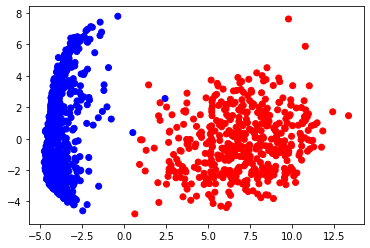

In [7]:
colors = []
for index in range(len(trainFeatures)):
    if(trainDigits[index]=="1.0"):
        colors.append("b")
    else:
        colors.append("r")

plt.scatter(trainPCA[:,0], trainPCA[:,1], c=colors)

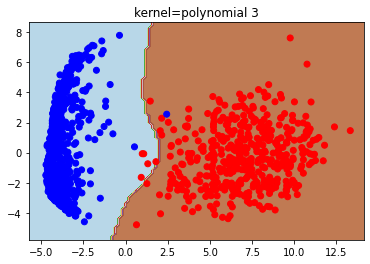

In [8]:
X = trainPCA
y= trainDigits

def plotSVC(title):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = (x_max - x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    plt.subplot(1, 1, 1)
    z = fit.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=colors, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.title(title)
    plt.show()
    pass

plotSVC('kernel='+ str('polynomial 3'))

I would say it does a better job of seperation than the two features selected from HW1. There is less overlap and the differences are more pronounced using PCA. 

The first vector explains 37.88% of the variance while the second vector explains 8.27% of the total variance. This is expected because it is our assumption for PCA that we take the largest eigenvalue for the first eigenvector used in PCA. We then go in descending order ranking the highest eigenvalues from largest to smallest. What we are trying to do is to maximize the variance explained with these vectors until we reach a suitable threshold. This is how we do dimensionality reduction for PCA so it makes sense the first eigenvector is explaining more variance.

# Logistic Regression

In [9]:
X = list(np.mean(trainFeatures, axis=1))
maxnumx = max(X)

Y = []
for i in range(len(trainFeatures)):
    x = trainFeatures[i][0:128]
    y = trainFeatures[i][128:]
    Y.append(pearsonr(x,y)[0])
maxnumy = max(Y)

MeanCorrelation = np.column_stack((X, Y))

In [10]:
clf_log = LogisticRegression(penalty='l2', C=.01)
fit_log = clf_log.fit(MeanCorrelation, trainDigits)

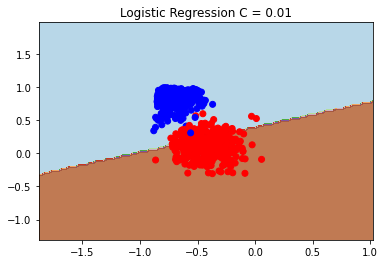

In [11]:
X = MeanCorrelation

def plotLog(title):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = (x_max - x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    plt.subplot(1, 1, 1)
    z = fit_log.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=colors, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.title(title)
    plt.show()
    pass

plotLog('Logistic Regression C = 0.01')

In [36]:
clf_log = LogisticRegression(penalty='l2', C=2.0)
fit_log = clf_log.fit(MeanCorrelation, trainDigits)

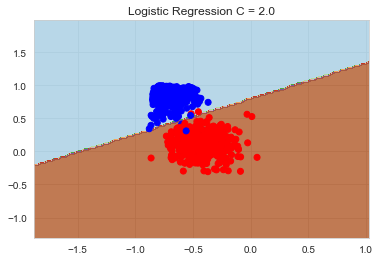

In [37]:
plotLog('Logistic Regression C = 2.0')

# Support Vector Machine

In [14]:
cList = np.arange(0.01, 5, 0.25)

In [15]:
cResults = []

for i in cList:
    clf = svm.SVC(C=i, kernel='linear')
    fit = clf.fit(MeanCorrelation, trainDigits) 
    scores = cross_val_score(fit, MeanCorrelation, trainDigits, cv=10, scoring='accuracy')
    cResults.append(1 - scores.mean())

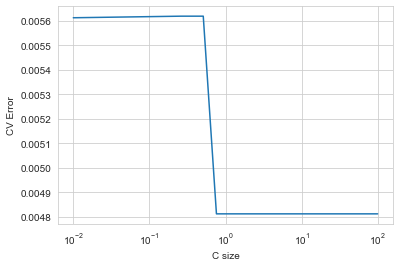

In [16]:
d = {'cResults': cResults, 'C': cList}
df = pd.DataFrame(data=d)
MeanMax = df.loc[df['cResults'].idxmin()]

sns.set_style('whitegrid')
fig = sns.lineplot(data=df, x="C", y="cResults")
plt.xscale('log')
plt.xlabel("C size")
plt.ylabel("CV Error")
plt.show(fig)

In [17]:
cResults_256 = []

for i in cList:
    clf = svm.SVC(C=i, kernel='linear')
    fit = clf.fit(trainFeatures, trainDigits) 
    scores = cross_val_score(fit, trainFeatures, trainDigits, cv=10, scoring='accuracy')
    cResults_256.append(1 - scores.mean())

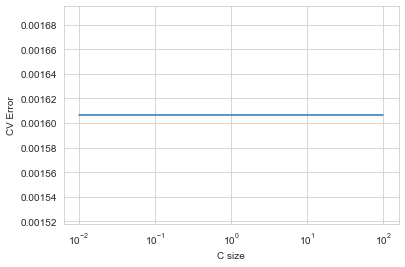

In [18]:
d = {'cResults': cResults_256, 'C': cList}
df = pd.DataFrame(data=d)
max_256 = df.loc[df['cResults'].idxmin()]

sns.set_style('whitegrid')
fig = sns.lineplot(data=df, x="C", y="cResults")
plt.xscale('log')
plt.xlabel("C size")
plt.ylabel("CV Error")
plt.show(fig)

In [19]:
MeanMax

cResults    0.004813
C           0.760000
Name: 3, dtype: float64

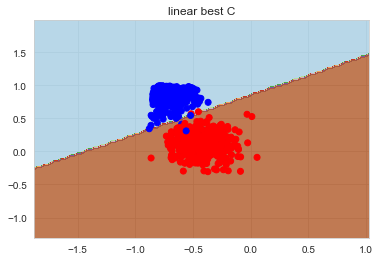

In [20]:
##decision region for max C on MeanCorrelation

clf = svm.SVC(C=0.760000, kernel='linear')
fit = clf.fit(MeanCorrelation, trainDigits)
X = MeanCorrelation


def plotSVC(title):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = (x_max - x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    plt.subplot(1, 1, 1)
    z = fit.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=colors, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.title(title)
    plt.show()
    pass

plotSVC('linear best C')

In [21]:
degree = [2,5,10,20]

kcResults_poly = []

for m in degree:
    for i in cList:
        clf = svm.SVC(C=i, kernel='poly', degree=m)
        fit = clf.fit(MeanCorrelation, trainDigits) 
        scores = cross_val_score(fit, MeanCorrelation, trainDigits, cv=10, scoring='accuracy')
        kcResults_poly.append(1 - scores.mean())
        kcResults_poly.append(m)
        kcResults_poly.append(i)


In [22]:
lst = list(kcResults_poly)
v1 = lst[0::3]
v2 = lst[1::3]
v3 = lst[2::3]

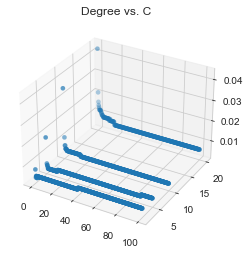

In [23]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(v3, v2, v1, linewidth=0.1)
ax.set_title('Degree vs. C')
plt.show()

In [24]:
l = {'cResults': v1, 'C': v3, 'Poly': v2}
dl = pd.DataFrame(data=l)
max_dl = dl.loc[dl['cResults'].idxmin()]  

In [25]:
print(dl.loc[dl['Poly']==2, 'cResults'].min())
print(dl.loc[dl['Poly']==5, 'cResults'].min())
print(dl.loc[dl['Poly']==10, 'cResults'].min())
print(dl.loc[dl['Poly']==20, 'cResults'].min())


0.00400645161290325
0.00400645161290325
0.004806451612903273
0.006406451612903319


In [26]:
print(dl.loc[(dl['Poly']==2) & (dl['cResults']==0.00400645161290325), 'C'])
print(dl.loc[(dl['Poly']==5) & (dl['cResults']==0.0040064516129032), 'C'])
print(dl.loc[(dl['Poly']==10) & (dl['cResults']==0.004806451612903273), 'C'])
print(dl.loc[(dl['Poly']==20) & (dl['cResults']==0.006406451612903319), 'C'])


1    0.26
5    1.26
6    1.51
Name: C, dtype: float64
Series([], Name: C, dtype: float64)
864     16.01
865     16.26
866     16.51
867     16.76
868     17.01
        ...  
1195    98.76
1196    99.01
1197    99.26
1198    99.51
1199    99.76
Name: C, Length: 336, dtype: float64
1267    16.76
1268    17.01
1269    17.26
1270    17.51
1271    17.76
        ...  
1595    98.76
1596    99.01
1597    99.26
1598    99.51
1599    99.76
Name: C, Length: 333, dtype: float64


From what we can see, when you put in a higher dimensional kernel, you need to adjust the cost function drastically. This make sense since the kernel is sending our values to degrees of 20 higher than their original. The function for these polynomial kernels is $K(x,y) = (x^Ty+c)^d$ so a cost that is less than 1 during the mapping is actually getting smaller. If we have a higher degree then we need a higher C  to keep up with the polynomial mapping.

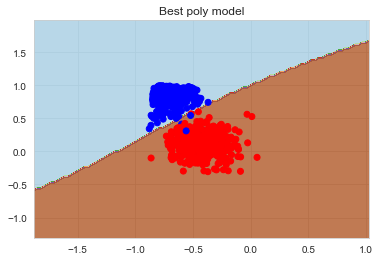

In [38]:
## best fit model for 2D data

clf = svm.SVC(C=1.26, kernel='poly', degree = 5)
fit = clf.fit(MeanCorrelation, trainDigits)
X = MeanCorrelation


def plotSVC(title):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = (x_max - x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    plt.subplot(1, 1, 1)
    z = fit.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=colors, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.title(title)
    plt.show()
    pass

plotSVC('Best poly model')

In [28]:
predictDigits = clf.predict(MeanCorrelation)
confusion_matrix(trainDigits, predictDigits)

array([[801,   4],
       [  1, 442]], dtype=int64)

In [29]:
clf = svm.SVC(C=1.26, kernel='poly', degree = 5)
fit = clf.fit(MeanCorrelation, trainDigits)
predictDigits = clf.predict(MeanCorrelation)
confusion_matrix(trainDigits, predictDigits)

array([[801,   4],
       [  1, 442]], dtype=int64)

In [30]:
clf = svm.SVC(C=16.01, kernel='poly', degree = 10)
fit = clf.fit(MeanCorrelation, trainDigits)
predictDigits = clf.predict(MeanCorrelation)
confusion_matrix(trainDigits, predictDigits)

array([[800,   5],
       [  1, 442]], dtype=int64)

In [31]:
clf = svm.SVC(C=16.76, kernel='poly', degree = 20)
fit = clf.fit(MeanCorrelation, trainDigits)
predictDigits = clf.predict(MeanCorrelation)
confusion_matrix(trainDigits, predictDigits)

array([[798,   7],
       [  1, 442]], dtype=int64)